# Flower Classification

In [22]:
# 필요없는 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [23]:
import tensorflow_datasets as tfds
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [24]:
#데이터 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


## Image load using matplolib

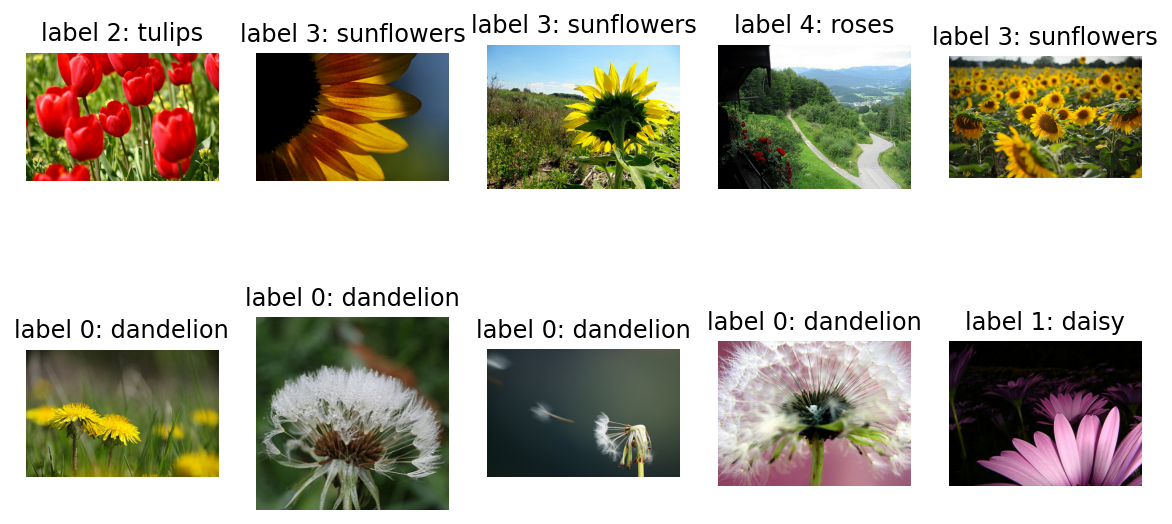

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# 더 높은 해상도 제공
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Image resize

In [5]:
import tensorflow as tf
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

## resize image load

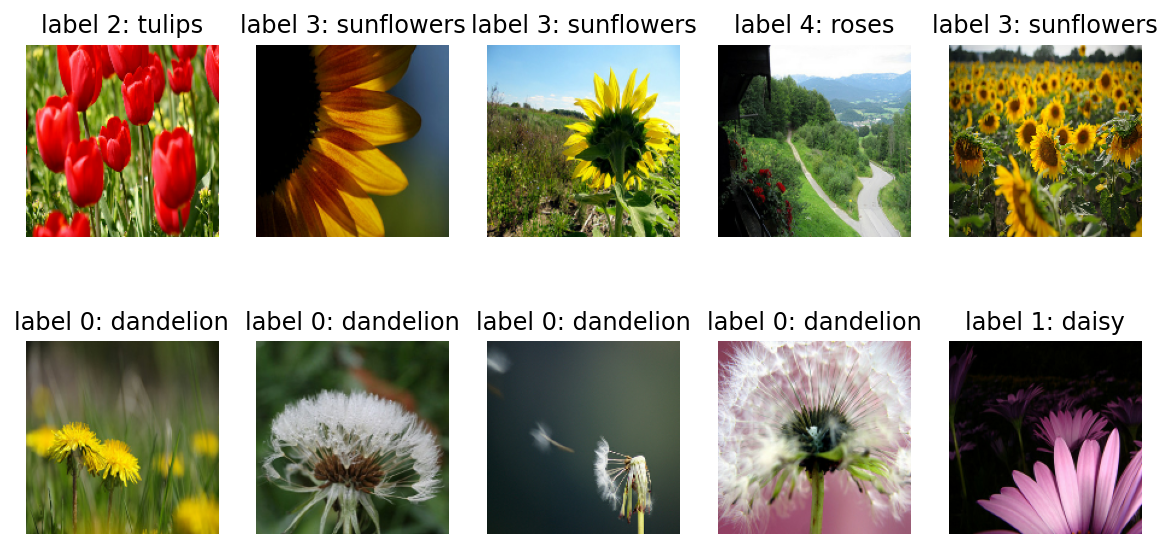

In [6]:
plt.figure(figsize=(10, 5))
#image shape (160, 160, 3)

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Set batch

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape


(TensorShape([32, 160, 160, 3]), TensorShape([32]))

## Transfer learning Flower with VGG16 Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         # 가까운 높은 레벨에 있는 3개의 FC 레이어는 제외하고 불러와야 하므로
                                         include_top=False,
                                         weights='imagenet')
image_batch.shape

TensorShape([32, 160, 160, 3])

In [9]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [10]:
# VGG16 모델 확인
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

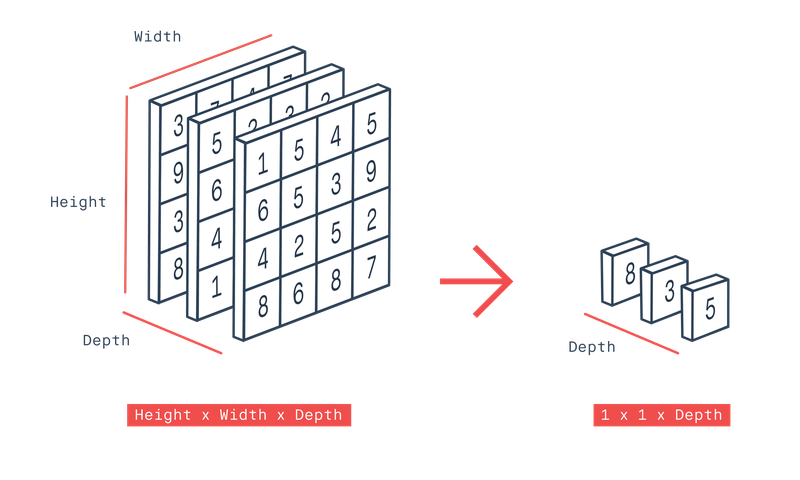

In [11]:
'''
VGG16 모델을 거치고 나온 Shape는 TensorShape([32, 5, 5, 512])
이를 Flat하게 만들어 줘야하는데
2차원 또는 3차원 벡터를 1차원으로 축소시키는 방법에는 Flattening 하는 것보다 조금 더 좋은 방법
바로 Global Average Pooling
'''
from IPython.display import Image
Image("Google_average_pooling.png")


## custormize model

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 512)
(32, 5)


In [33]:
#VGG16 base 모델은 W값 수정 X
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
validation_steps=12
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 1s 69ms/step - loss: 1.6700 - accuracy: 0.1553
initial loss: 1.67
initial accuracy: 0.16


In [39]:
EPOCHS = 10   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 9s 93ms/step - loss: 0.6376 - accuracy: 0.7936 - val_loss: 0.6358 - val_accuracy: 0.7766
Epoch 2/10
92/92 [==============================] - 9s 93ms/step - loss: 0.6008 - accuracy: 0.8035 - val_loss: 0.6008 - val_accuracy: 0.7902
Epoch 3/10
92/92 [==============================] - 9s 94ms/step - loss: 0.5741 - accuracy: 0.8185 - val_loss: 0.5839 - val_accuracy: 0.7956
Epoch 4/10
92/92 [==============================] - 9s 93ms/step - loss: 0.5495 - accuracy: 0.8202 - val_loss: 0.5772 - val_accuracy: 0.7875
Epoch 5/10
92/92 [==============================] - 9s 94ms/step - loss: 0.5305 - accuracy: 0.8304 - val_loss: 0.5520 - val_accuracy: 0.8093
Epoch 6/10
92/92 [==============================] - 9s 94ms/step - loss: 0.5106 - accuracy: 0.8321 - val_loss: 0.5400 - val_accuracy: 0.8093
Epoch 7/10
92/92 [==============================] - 9s 94ms/step - loss: 0.4977 - accuracy: 0.8389 - val_loss: 0.5462 - val_accuracy: 0.8065
Epoch 8/10
92

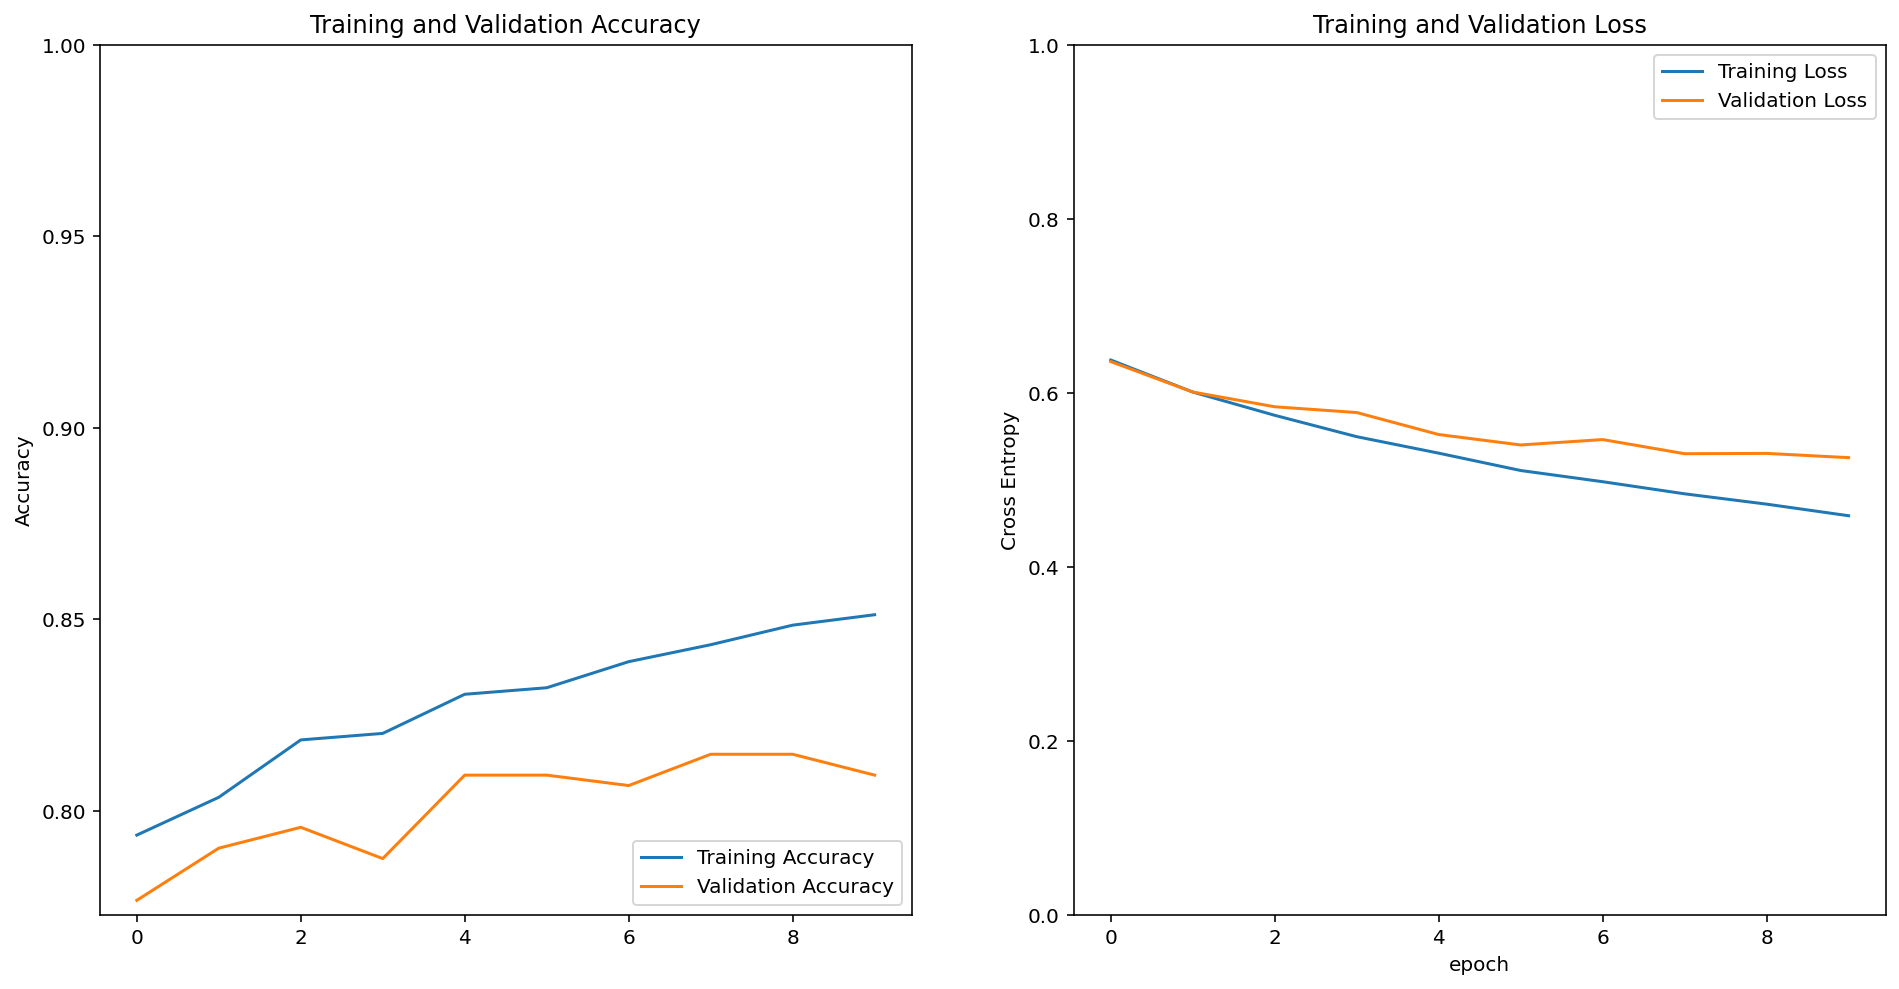

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.46028546e-02, 5.18211424e-02, 7.31402755e-01, 6.91630244e-02,
        1.23010173e-01],
       [9.99371469e-01, 5.20088128e-04, 2.19211688e-06, 5.85366470e-05,
        4.76869536e-05],
       [8.04772019e-01, 7.04990998e-02, 1.14742899e-02, 9.92876887e-02,
        1.39669273e-02],
       [2.10864306e-03, 7.46990973e-03, 5.44487655e-01, 8.71298928e-03,
        4.37220842e-01],
       [7.48423278e-01, 2.12693900e-01, 8.42540059e-03, 1.44754285e-02,
        1.59819610e-02],
       [9.36074078e-01, 3.77851538e-02, 2.67230230e-03, 2.22663805e-02,
        1.20213069e-03],
       [1.01108514e-02, 1.00972215e-02, 7.74207890e-01, 1.40360683e-01,
        6.52233660e-02],
       [5.04751801e-01, 3.81031424e-01, 6.71746151e-04, 1.10981770e-01,
        2.56322976e-03],
       [7.06461072e-03, 7.11922126e-04, 1.30684897e-02, 9.30643439e-01,
        4.85115945e-02],
       [9.99495625e-01, 4.46770864e-04, 2.76318616e-07, 5.58473403e-05,
        1.43347904e-06],
       [9.77813482e-01, 1.7686

In [42]:
#라벨 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

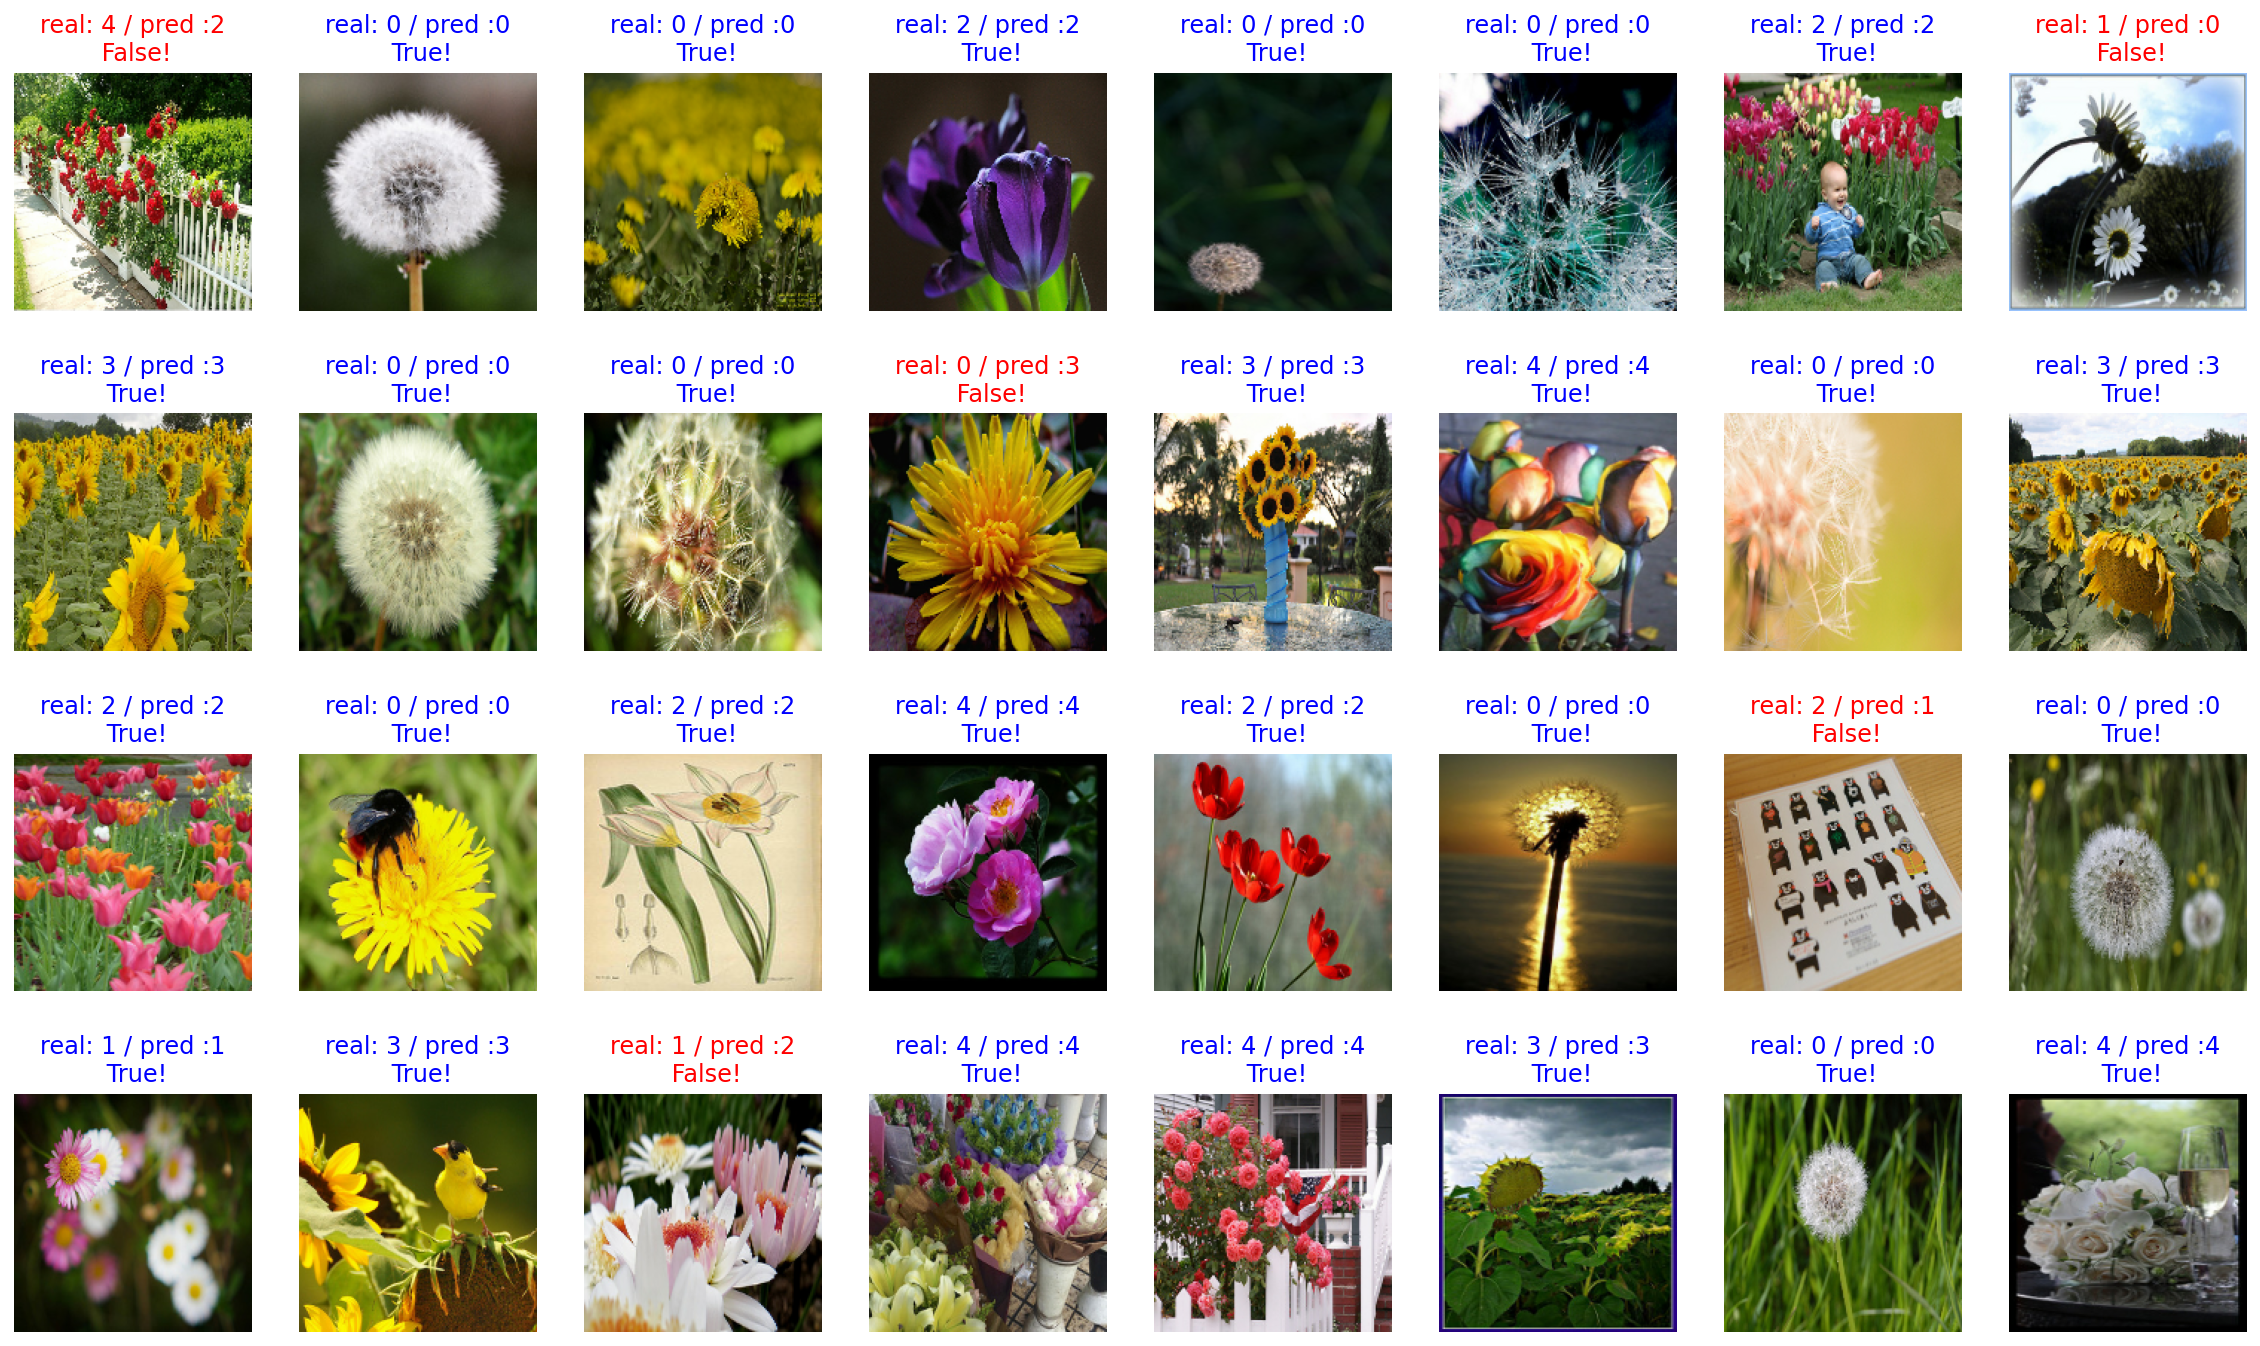

In [43]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [47]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print('{}%'.format(count / 32 * 100))

84.375%


In [48]:
import os

checkpoint_dir = os.getenv("HOME") + "/project/AIFFEL_Study/e4_image_classifier/flower/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


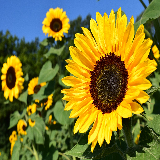

In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_dir_path = os.getenv("HOME") + "/project/AIFFEL_Study/e4_image_classifier/flower/images"
os.path.exists(img_dir_path)

IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'sunflower.jpg')

sunflower_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
sunflower_image

In [51]:
sunflower_image = img_to_array(sunflower_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
sunflower_image.shape

(1, 160, 160, 3)

In [52]:
prediction = model.predict(sunflower_image)
prediction

array([[0.0000000e+00, 2.5242886e-10, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00]], dtype=float32)

## make predict_image Func

In [69]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflowers_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    print(f"This image seems {sunflowers_percentage}% sunflowers, and {tulips_percentage}% tulips, and {daisy_percentage}% dasiy, and {dandelion_percentage}% dandelion, and {roses_percentage}% roses.")

This image seems 100% sunflowers, and 0% tulips, and 0% dasiy, and 0% dandelion, and 0% roses.


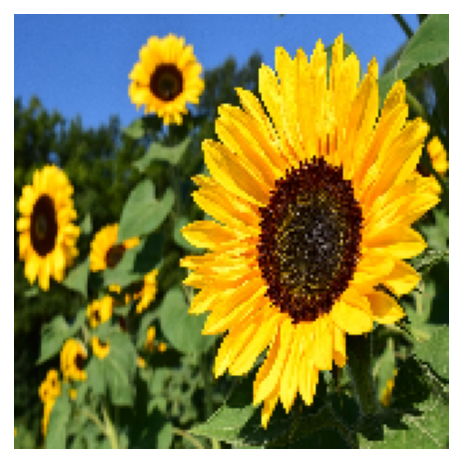

In [70]:
filename = 'sunflower.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% sunflowers, and 0% tulips, and 100% dasiy, and 0% dandelion, and 0% roses.


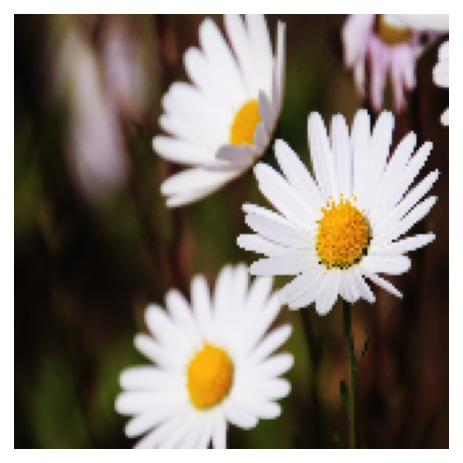

In [76]:
filename = 'daisy.jpeg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% sunflowers, and 0% tulips, and 0% dasiy, and 100% dandelion, and 0% roses.


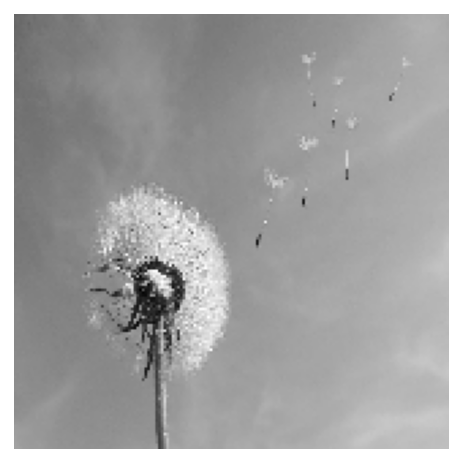

In [81]:
filename = 'dandelion.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% sunflowers, and 1% tulips, and 0% dasiy, and 0% dandelion, and 99% roses.


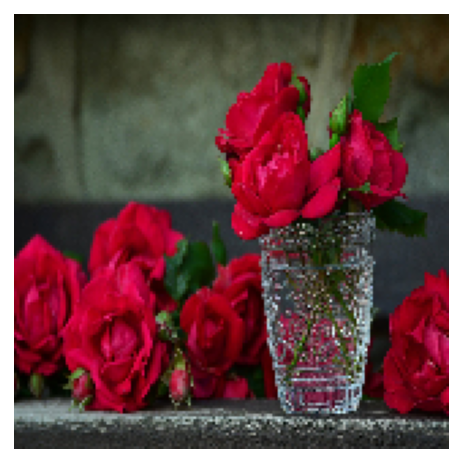

In [79]:
filename = 'roses.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% sunflowers, and 100% tulips, and 0% dasiy, and 0% dandelion, and 0% roses.


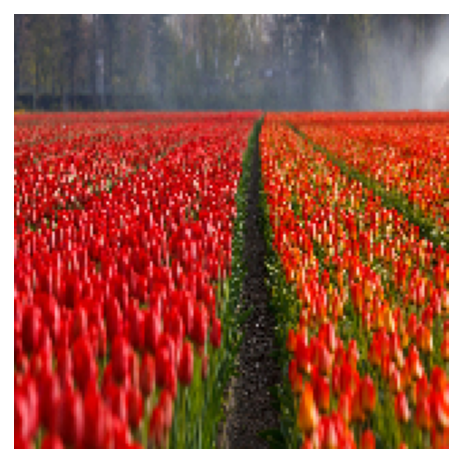

In [80]:
filename = 'tulips.jpg'

show_and_predict_image(img_dir_path, filename)